In [100]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image
# import keras
# import keras.backend as K
# from skimage.util.montage import montage2d
from skimage.io import imread
from scipy.io import loadmat # for loading mat files
from tqdm import tqdm_notebook
# root_mpi_dir = os.path.join('..', 'data', 'MPII')
# data_dir = os.path.join(root_mpi_dir, 'Data')
# annot_dir = os.path.join(root_mpi_dir, 'Annotation Subset') # annotations the important part of the data
# img_dir = os.path.join(data_dir, 'Original')

import torch
import torchvision
from torch.utils import data
from torch.utils.data import Dataset
import os
from os import listdir
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



In [4]:
mpii_path = '../data/MPII'
images_path = os.path.join(mpii_path, 'images')
annot_path = os.path.join(mpii_path, 'annot')

In [41]:
train_annot = h5py.File(annot_path + '/train.h5', 'r')
test_annot = h5py.File(annot_path + '/train.h5', 'r')
valid_annot = h5py.File(annot_path + '/train.h5', 'r')

In [8]:
train_annot.keys()

<KeysViewHDF5 ['center', 'imgname', 'index', 'name', 'name_', 'normalize', 'part', 'person', 'scale', 'torsoangle', 'visible']>

In [36]:
img_names = np.array(train_annot.get('imgname'))

In [48]:
joints = np.array(train_annot.get('part'))

In [57]:
person = np.array(train_annot.get('person'))
print(person.shape)

(22246,)


In [55]:
test_person = person[1]

In [56]:
test_person

1

In [89]:
test_img = img_names[63]
test_joints = joints[63]

In [90]:
test_img_path = os.path.join(images_path, test_img.decode("utf-8"))

In [91]:
test_img_path

'../data/MPII/images/082873751.jpg'

In [92]:
test_im = Image.open(test_img_path)

In [93]:
test_joints.shape

(16, 2)

In [96]:
rank = test_joints[0]
rknee = test_joints[1]
rhip = test_joints[2]
lhip = test_joints[3]
lknee = test_joints[4]
lank = test_joints[5]

groin = test_joints[6]
chest = test_joints[7]
neck = test_joints[8]
head = test_joints[9]

rwrist = test_joints[10]
relb = test_joints[11]
rshould = test_joints[12]
lshould = test_joints[13]
lelb = test_joints[14]
lwrist = test_joints[15]


In [103]:
test_joints.flatten()

array([720., 638., 707., 524., 684., 365., 784., 366., 792., 520., 797.,
       649., 734., 366., 739., 175., 737., 153., 732.,  47., 694., 378.,
       659., 288., 683., 176., 795., 174., 803., 294., 771., 377.])

In [97]:
connected_pairs = [(0,1), (1, 2), (2,6), (6,3), (3,4), (4,5), 
                   (6,7), (7,8), (8,9), (8,12), (12,11), (11,10), 
                  (8,13), (13, 14), (14, 15)]

In [128]:
np.array(test_im).shape

(720, 1280, 3)

In [182]:
test_im2 = test_im.resize((96,96))

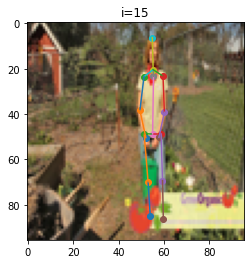

In [188]:
plt.imshow(test_im2)

og_rows = np.array(test_im).shape[0]
og_cols = np.array(test_im).shape[1]

Ry = (96/og_rows)
Rx = (96/og_cols)

for i in range(test_joints.shape[0]):
    plt.scatter(test_joints[i][0]*Rx, test_joints[i][1]*Ry)

for (p1, p2) in connected_pairs:
    x = [test_joints[p1][0]*Rx, test_joints[p2][0]*Rx]
    y = [test_joints[p1][1]*Ry, test_joints[p2][1]*Ry]
    plt.plot(x, y)
    
plt.title('i='+ str(i))
plt.show()

In [189]:
print(Ry)
print(Rx)

0.13333333333333333
0.075


# Make Dataset

In [197]:
train_annot = h5py.File(annot_path + '/train.h5', 'r')
train_img_names = np.array(train_annot.get('imgname'))
train_joints = np.array(train_annot.get('part'))

train_labels_dict = {}
train_images_dict = {}

Ry=0.13333333333333333
Rx=0.075

for i in range(len(train_img_names)):
    curr_img = train_img_names[i].decode("utf-8")
    curr_joints = train_joints[i]
    for j in range(len(curr_joints)):
        new_x = Rx * curr_joints[j][0]
        new_y = Ry * curr_joints[j][1]
        curr_joints[j][0] = new_x
        curr_joints[j][1] = new_y
    
    curr_joints = curr_joints.flatten()
    
    train_labels_dict[i] = curr_joints
    train_images_dict[i] = curr_img


In [244]:
class MPII_Dataset(data.Dataset):
#       '''Characterizes a dataset for PyTorch'''
    def __init__(self, labels, images, images_path):
        '''Initialization'''
        self.labels = labels
        self.images = images
        
        self.images_path = images_path
        
        self.transform = transforms.Compose(
                [
                    transforms.Resize((96, 96)),
                    transforms.ToTensor(),
#                     transforms.CenterCrop(10),
                 
                 transforms.Normalize((0.5, 0.5, 0.5), 
                                      (0.5, 0.5, 0.5))])

    def __len__(self):
        '''Denotes the total number of samples'''
        return len(self.labels)

    def __getitem__(self, index):
        '''Generates one sample of data'''
        # Select sample
        image_filename = self.images[index]
        path_to_image = os.path.join(self.images_path, image_filename)

        # Load data and get label
        image = Image.open(path_to_image)
        image = self.transform(image).float()
        x = image
        y = torch.tensor(np.array(self.labels[index])).float()

        return x, y

In [245]:
train_dataset = MPII_Dataset(train_labels_dict, train_images_dict, images_path)

In [246]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=256,
                                          shuffle=True,
                                         )


In [201]:
x1,y1 = train_dataset.__getitem__(63)

In [202]:
x1.shape

torch.Size([3, 96, 96])

In [203]:
iterations = 5000 
lr = 0.01
momentum = 0.9

In [204]:
test_x1 = np.swapaxes(x1, 0,2)
test_x1 = np.swapaxes(test_x1, 0,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


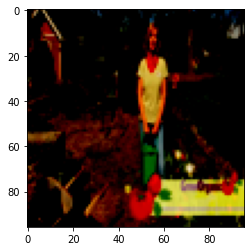

In [205]:
plt.imshow(test_x1)
plt.show()

In [247]:
class PoseNet(nn.Module):
    def __init__(self):
        super(PoseNet, self).__init__()
        # torch.Size([256, 3, 96, 96])
        # 3 input image channel (RGB), #6 output channels, 4x4 kernel 
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(18432, 500)
        self.fc2 = nn.Linear(500, 96)
        self.fc3 = nn.Linear(96, 32)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         print(x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
#         print(x.shape)
        
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        output = x
#         output = F.log_softmax(x, dim=1)
        return output
        
        

In [252]:
max_epochs = 5000 
lr = 0.01
momentum = 0.9

pose_net1 = PoseNet().double()
# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.RMSprop(pose_net1.parameters(), lr=lr, momentum=momentum)


In [254]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
# params = {'batch_size': 64,
#           'shuffle': True,
#           'num_workers': 6}


training_losses = []

# Generators
training_set = train_dataset
training_generator = train_data_loader

loss_fn = torch.nn.SmoothL1Loss(reduction='sum')

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    total_epoch_loss = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(training_generator):
        
        batch_data = batch_data.double()
        batch_labels = batch_labels.double()
        
        predicted_output = pose_net1(batch_data)
                                        
        predicted_output = predicted_output.double()                                
        target_output = batch_labels
        
       
        loss = loss_fn(predicted_output, target)

        pose_net1.zero_grad()
        loss.backward()
        
        optimizer.step()  
        
        total_epoch_loss += loss.item()
    
        if batch_idx % 25 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, total_epoch_loss))
    
#     if epoch % 100 == 0:
#         with open('../saved_models/pose_network_1.pkl', 'wb') as f:
#             torch.save(pose_net1.state_dict(), f)
            
    training_losses.append(total_epoch_loss)
    
# with open('../saved_models/pose_network_1_final.pkl', 'wb') as f:
#     torch.save(pose_net1.state_dict(), f)
    
# with open('../saved_models/training_losses_1.npy', 'wb') as f:
#     np.save(f, np.array(training_losses))

Train Epoch: 0 	Loss: 3416494.939026


KeyboardInterrupt: 